In [235]:
import contextlib
import math
import os
import sys
import random
import toml
import dill as pickle
import numpy as np
from functools import partial
from csv import DictReader
from datetime import datetime
from functools import cached_property
from typing import Iterable, Callable, Sequence, Optional
from dataclasses import dataclass, asdict
from matplotlib import pyplot as plt

# Load the configuration from the config.toml file
config = toml.load("config.toml")

# Access the configurations
LINES_COUNT_TO_READ = config["general"]["LINES_COUNT_TO_READ"]
TRAIN_TEST_SPLIT_RATIO = config["general"]["TRAIN_TEST_SPLIT_RATIO"]

ALS_HYPER_N_EPOCH = config["als"]["HYPER_N_EPOCH"]
ALS_HYPER_N_FACTOR = config["als"]["HYPER_N_FACTOR"]
ALS_HYPER_GAMMA = config["als"]["HYPER_GAMMA"]
ALS_HYPER_LAMBDA = config["als"]["HYPER_LAMBDA"]
ALS_HYPER_TAU = config["als"]["HYPER_TAU"]
ALS_CHECKPOINT_FOLDER = config["als"]["CHECKPOINT_FOLDER"]

PLT_FIGURE_FOLDER = config["figures"]["PLT_FIGURE_FOLDER"]
PLT_FIGURE_FORMAT = config["figures"]["PLT_FIGURE_FORMAT"]


class logger:  # noqa
    # Fake logger
    log = staticmethod(print)

In [236]:
import doctest
from abc import ABC, abstractmethod
from collections import defaultdict, Counter


class AbstractSerialMapper(ABC):

    NOTHING = object()

    def __init__(self):
        self._data = []

    @abstractmethod
    def add(self, value, *args, **kwargs):
        pass

    def __len__(self):
        return len(self._data)

    def __getitem__(self, key):
        with contextlib.suppress(IndexError):
            return self._data[key]

    def __iter__(self):
        """Iterates through the indices from 0 to len(self._data)"""
        return iter(range(self.__len__()))


class SerialUnidirectionalMapper(AbstractSerialMapper):
    def __init__(self):
        super().__init__()

    def add(self, data, *args, key=None, **kwargs):
        if key is None:
            self._data.append([] if data is self.NOTHING else [data])
        else:
            self._data[key].append(data)


class SerialBidirectionalMapper(AbstractSerialMapper):

    def __init__(self):
        super().__init__()
        self._data = []
        self._inverse_data = defaultdict(lambda: None)

    def __getitem__(self, key):
        return self._data[key]

    def add(self, data, *args, **kwargs):
        self._inverse_data[data] = len(self._data)
        self._data.append(data)

    @property
    def inverse(self):
        return self._inverse_data


class InMemory2DIndexer(object):
    """
    An in-memory 2D indexer for efficiently store users, items and their related data from a CSV file.

    This class provides an efficient mechanism to map and store large datasets
    using bijective mappings between user/item names and their corresponding IDs.

    Example usage:
        >>> # Testing the creation of an in-memory 2D indexer
        >>> InMemory2DIndexer.create_from_csv(
        ...     file_path="./ml-32m/ratings.csv",
        ...     user_header="userId",
        ...     item_header="movieId",
        ...     rating_header="rating",
        ...     limit=10
        ... )  # doctest:+ELLIPSIS
        Limit of entries (.i.e 10) to load has been reached. Exiting without loading the rest...
        <__main__.InMemory2DIndexer object at ...
        >>> # Testing that we can load data effectively
        >>> indexed_data = InMemory2DIndexer.create_from_csv(
        ...     file_path="./ml-32m/ratings.csv",
        ...     user_header="userId",
        ...     item_header="movieId",
        ...     rating_header="rating",
        ...     limit=400
        ... )  # doctest:+ELLIPSIS
        Limit of entries (.i.e 400) to load has been reached. Exiting without loading the rest...
        >>> # Testing the content of the indexed_data
        >>> # Expect `users_count` to be 5 for the 400th lines indexed
        >>> indexed_data.users_count == 5
        True
        >>> # Expect `items_count` to be 327 for the 400th lines indexed
        >>> indexed_data.items_count == 327
        True
        >>> indexed_data.id_to_user_bmap._data
        ['1', '2', '3', '4', '5']
    """

    LIMIT_TO_LOAD_IN_MEMORY = 1_000_000_000_000

    def __init__(self):
        self.id_to_item_bmap = SerialBidirectionalMapper()  # bijective mapping
        self.id_to_user_bmap = SerialBidirectionalMapper()
        self.data_by_user_id = SerialUnidirectionalMapper()  # subjective mapping
        self.data_by_item_id = SerialUnidirectionalMapper()

    def _construct_data(self, data, items):  # noqa
        return (
            self._data_constructor(data, items)
            if self._data_constructor is not None
            else data
        )

    def _initialize_extra_attributes(
        self,
        *,
        user_header: str,
        item_header: str,
        rating_header: str,
        file_path: str,
        data_headers: Iterable = None,
        data_constructor: Callable = None,
        limit: int = None,
        verbose: bool = False,
    ):
        self._user_header = user_header
        self._item_header = item_header
        self._rating_header = rating_header
        self._file_path = file_path
        self._verbose = verbose
        self._data_headers = data_headers
        self._data_constructor = data_constructor
        self._limit = limit or self.LIMIT_TO_LOAD_IN_MEMORY

    @classmethod
    def create_from_csv(
        cls,
        *,
        file_path: str,
        user_header: str,
        item_header: str,
        rating_header: str,
        data_headers: Iterable = None,
        data_constructor: Callable = None,
        limit: int = None,
        verbose: bool = False,
    ) -> "InMemory2DIndexer":

        self = cls()
        self._initialize_extra_attributes(
            user_header=user_header,
            item_header=item_header,
            rating_header=rating_header,
            file_path=file_path,
            data_headers=data_headers,
            data_constructor=data_constructor,
            limit=limit,
            verbose=verbose,
        )

        indexed_count = 0

        try:
            with open(file_path, mode="r", newline="") as csvfile:
                for line_count, line in enumerate(DictReader(csvfile)):
                    user, item = line[self._user_header], line[self._item_header]
                    # Unlikely in this dataset but better have this guard
                    if not all([user, item]):
                        logger.log(
                            f"Cannot process the line {line_count}, cause expects `user` and `item` to be defined but got {user} and {item} for them respectively, skipping..."
                        )
                        continue

                    user_id = self.id_to_user_bmap.inverse[user]
                    item_id = self.id_to_item_bmap.inverse[item]

                    if user_id is None:
                        # This user is a new one, so add it
                        self.id_to_user_bmap.add(user)

                    if item_id is None:
                        # This item is a new one, so add it
                        self.id_to_item_bmap.add(item)

                    # Add the data without the useless items for indexing
                    data = self._construct_data(line, data_headers)

                    self.data_by_user_id.add(data=data, key=user_id)
                    self.data_by_item_id.add(data=data, key=item_id)

                    if verbose:
                        logger.log(
                            f"Indexed the line {indexed_count} of {file_path} successfully"
                        )

                    indexed_count += 1
                    if indexed_count == self._limit:
                        logger.log(
                            f"Limit of entries (.i.e {limit}) to load has been reached. Exiting without loading the rest... "
                        )
                        break

            # Return the created instance
            return self
        except (FileNotFoundError, KeyError) as exc:
            logger.log(
                f"Cannot create `InMemory2DIndexer` instance from the given `file_path` .i.e {file_path}. Attempt failed with exception {exc}"
            )
            raise  # Intentional crash

    @property
    def users_count(self) -> int:
        return len(self.id_to_user_bmap)

    @property
    def items_count(self) -> int:
        return len(self.id_to_item_bmap)

    @cached_property
    def user_id_degree_map(self):
        return {
            user_id: len(self.data_by_user_id[user_id])
            for user_id in self.id_to_user_bmap
        }

    @cached_property
    def item_id_degree_map(self):
        return {
            item_id: len(self.data_by_item_id[item_id])
            for item_id in self.id_to_item_bmap
        }

    def getdata_by_user_id(self, user_id):
        return self.data_by_user_id[user_id]

    def getdata_by_item_id(self, item_id):
        return self.data_by_item_id[item_id]

    def plot_data_item_distribution_as_hist(
        self,
        data_item: str,
        plot_title: str = "Ratings distribution",
        plot_xlabel: str = "Ratings",
        plot_ylabel: str = "Count",
    ):
        # TODO: Use this link to fix https://stackoverflow.com/questions/23246125/how-to-center-labels-in-histogram-plotx hist
        data_to_plot = []
        for user_id in self.id_to_user_bmap:
            for data in self.data_by_user_id[user_id]:
                data_to_plot.append(data[data_item])

        plt.figure(figsize=(10, 6))
        plt.hist(data_to_plot, bins=10, edgecolor="black")
        plt.title(plot_title)
        plt.xlabel(plot_xlabel)
        plt.ylabel(plot_ylabel)

        plt.savefig(
            get_plt_figure_path("ratings_distribution"), format=PLT_FIGURE_FORMAT
        )
        plt.show()

    def plot_power_low_distribution(self):  # noqa

        user_degrees_occurrences = self.user_id_degree_map
        movie_degrees_occurrences = self.item_id_degree_map
        user_degrees_occurrences_counter = Counter(user_degrees_occurrences.values())
        movie_degrees_occurrences_counter = Counter(movie_degrees_occurrences.values())

        fig, ax = plt.subplots(figsize=(6, 4))

        ax.scatter(
            user_degrees_occurrences_counter.keys(),
            user_degrees_occurrences_counter.values(),
            label="Users",
        )
        ax.scatter(
            movie_degrees_occurrences_counter.keys(),
            movie_degrees_occurrences_counter.values(),
            label="Movies",
        )
        ax.set_title("Degree distribution")
        ax.set_xlabel("Degree")
        ax.set_ylabel("Frequency")
        ax.legend()

        plt.yscale("log")
        plt.xscale("log")

        plt.savefig(get_plt_figure_path("power_low"), format=PLT_FIGURE_FORMAT)

        plt.show()

    def split_into_train_test(self, ratio: float):

        data_by_user_id__train = SerialUnidirectionalMapper()  # noqa
        data_by_item_id__train = SerialUnidirectionalMapper()  # noqa
        data_by_user_id__test = SerialUnidirectionalMapper()  # noqa
        data_by_item_id__test = SerialUnidirectionalMapper()  # noqa

        visited_user_ids = set()
        visited_item_ids = set()

        dataset_indices_based_representation = [
            (user_id, user_item_id)
            for user_id in range(self.users_count)
            for user_item_id in range(self.user_id_degree_map[user_id])
        ]

        test_dataset_indices_based_representation = set(
            random.sample(
                dataset_indices_based_representation,
                math.floor(len(dataset_indices_based_representation) * ratio),
            )
        )

        for user_id, user_item_id in dataset_indices_based_representation:
            # Get the item_id using the `user_item_id`
            data = indexed_data.data_by_user_id[user_id][user_item_id]
            rating, item = data[self._rating_header], data[self._item_header]
            item_id = indexed_data.id_to_item_bmap.inverse[item]

            if (
                user_id,
                user_item_id,
            ) in test_dataset_indices_based_representation:

                # We are having this user for the first time
                if user_id not in visited_user_ids:
                    # Add the user and its first rating data
                    data_by_user_id__test.add(
                        indexed_data.data_by_user_id[user_id][user_item_id]
                    )
                    # Add the user_id but with an empty array; this helps to ensure that
                    # the test set and the training set will have the same dimension
                    data_by_user_id__train.add(SerialUnidirectionalMapper.NOTHING)
                    visited_user_ids.add(user_id)
                else:
                    # The user has already been added
                    data_by_user_id__test.add(
                        indexed_data.data_by_user_id[user_id][user_item_id], key=user_id
                    )

                # DEAL WITH ITEMS

                if item_id not in visited_item_ids:
                    data_by_item_id__test.add(
                        {
                            self._user_header: indexed_data.id_to_user_bmap[user_id],
                            self._rating_header: rating,
                        }
                    )
                    data_by_item_id__train.add(SerialUnidirectionalMapper.NOTHING)
                    visited_item_ids.add(item_id)
                else:
                    # The item has already been added both in the training and the test dataset
                    data_by_item_id__test.add(
                        {
                            self._user_header: indexed_data.id_to_user_bmap[user_id],
                            self._rating_header: rating,
                        },
                        key=item_id,
                    )
            else:
                # We've got an occurrence that should be used as a training dataset
                if user_id not in visited_user_ids:

                    data_by_user_id__train.add(
                        indexed_data.data_by_user_id[user_id][user_item_id]
                    )
                    # Add the user entry, but with an empty array
                    data_by_user_id__test.add(SerialUnidirectionalMapper.NOTHING)
                    visited_user_ids.add(user_id)
                else:
                    data_by_user_id__train.add(
                        indexed_data.data_by_user_id[user_id][user_item_id], key=user_id
                    )

                # DEAL WITH ITEMS

                if item_id not in visited_item_ids:
                    data_by_item_id__test.add(SerialUnidirectionalMapper.NOTHING)

                    data_by_item_id__train.add(
                        {
                            self._user_header: indexed_data.id_to_user_bmap[user_id],
                            self._rating_header: rating,
                        }
                    )

                    visited_item_ids.add(item_id)

                else:
                    # The item has already been added both in the training and the testing dataset
                    data_by_item_id__train.add(
                        {
                            self._user_header: indexed_data.id_to_user_bmap[user_id],
                            self._rating_header: rating,
                        },
                        key=item_id,
                    )

        return (data_by_user_id__train, data_by_item_id__train), (
            data_by_user_id__test,
            data_by_item_id__test,
        )


# Test that the indexer works well before proceeding
doctest.testmod(report=True, verbose=True)

Trying:
    als = AlternatingLeastSquares(lambda user_id: 0, lambda item_id: 0, (2, 2))
Expecting nothing
**********************************************************************
File "__main__", line ?, in __main__.AlternatingLeastSquares
Failed example:
    als = AlternatingLeastSquares(lambda user_id: 0, lambda item_id: 0, (2, 2))
Expected nothing
Got:
    Successfully initialized the model state to: AlsState(user_factors=array([[ 0.00625159, -0.00489029,  0.04188436, -0.30314701,  0.1982238 ,
            -0.2419404 ,  0.02326372, -0.52766156, -0.36711194,  0.29190548],
           [ 0.46248528,  0.34208045, -0.58733893, -0.80217569,  0.02306409,
            -0.10167427, -0.07324822,  0.26227321, -0.16851158,  0.24312008]]), item_factors=array([[ 0.18795869,  0.0034523 ,  0.20184434,  0.46571004,  0.03321035,
            -0.39285574,  0.151564  , -0.24374654, -0.22655264, -0.2822509 ],
           [-0.39327794,  0.3487168 , -0.36042528,  0.33746245, -0.02930671,
            -0.18848028,

TestResults(failed=9, attempted=19)

In [237]:
def generate_kwargs_based_name(prefix="", extension="", **kwargs):
    """
    Generate filename based on the provided kwargs. Useful to create
    checkpoints filename and figure names based on the config of the
    environment.

    Parameters:
        prefix (str): Optional prefix to add at the beginning of the filename.
        extension (str): Optional file extension to add at the end of the filename.
        **kwargs: Key-value pairs to be included in the filename.

    Returns:
        str: Generated filename with timestamp and provided keyword arguments.

    Examples:
        >>> generate_kwargs_based_name(prefix="checkpoint", extension="pt", lambda_=0.1, gamma=0.5, tau=0.2)
        'checkpoint_20231028-152433_lambda0.1_gamma0.5_tau0.2.pt'

        >>> generate_kwargs_based_name(prefix="plot", extension="svg", width=800, height=600)
        'plot_20231028-152433_width800_height600.svg'
    """

    # This is a special case that we want to support. And this is
    # due to the fact that `lambda` is a reserved word is python
    _lambda = kwargs.pop("lambda_", None) or kwargs.pop("_lambda", None)
    kwargs["lambda"] = _lambda

    prefix = prefix or ""
    extension = f".{extension}" if extension else ""

    # Create a readable timestamp
    readable_timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

    # Construct the filename with provided keyword arguments
    filename_parts = [readable_timestamp, f"lambda{_lambda}"]
    for key, value in kwargs.items():
        filename_parts.append(f"{key}{value}")

    if prefix:
        filename_parts.insert(0, prefix)
    if extension:
        filename_parts.append(extension)

    # Join all parts with underscores
    return "_".join(filename_parts)


generate_config_based_name = partial(
    generate_kwargs_based_name,
    _lambda=ALS_HYPER_LAMBDA,
    gamma=ALS_HYPER_GAMMA,
    tau=ALS_HYPER_TAU,
    epochs=ALS_HYPER_N_EPOCH,
    factors=ALS_HYPER_N_FACTOR,
    # The dataset lines count
    input=LINES_COUNT_TO_READ,
)


def get_plt_figure_path(figure_name, subdir=""):
    """
    Return a path to save the figure to
    """
    config_based_figure_name = generate_config_based_name(
        prefix=figure_name, extension=PLT_FIGURE_FORMAT
    )
    return (
        f"{PLT_FIGURE_FOLDER}/{subdir}/{config_based_figure_name}"
        if subdir
        else f"{PLT_FIGURE_FOLDER}/{config_based_figure_name}"
    )

In [238]:
class CheckpointManager(object):
    def __init__(self, checkpoint_folder):
        self.checkpoint_folder = checkpoint_folder

    def _get_checkpoint_path(self, checkpoint_name):
        """
        Join fs folders with file
        """
        if not checkpoint_name:
            return

        # Split the path to check for file extension
        checkpoint_name = (
            checkpoint_name
            if (checkpoint_name.endswith(".pkl"))
            else f"{checkpoint_name}.pkl"
        )
        return os.path.join(self.checkpoint_folder, checkpoint_name)

    def save(self, state, checkpoint_name):
        os.makedirs(self.checkpoint_folder, exist_ok=True)
        checkpoint_path = self._get_checkpoint_path(checkpoint_name)
        with open(checkpoint_path, "wb") as f:
            pickle.dump(state, f)

    def load(self) -> dict:
        pass

    def list(self):
        pass

    def delete(self):
        pass


@dataclass
class AlsState:
    user_factors: Optional[Sequence]
    item_factors: Optional[Sequence]
    user_biases: Optional[Sequence]
    item_biases: Optional[Sequence]
    hyper_lambda: float
    hyper_tau: float
    hyper_gamma: float
    hyper_n_epochs: int
    hyper_n_factors: int

    InvalidStateError = type("InvalidStateError", (AttributeError,), {})

    @classmethod
    def create_from(cls, data: dict) -> "AlsState":  # noqa
        return cls(
            user_factors=data["user_factors"],
            item_factors=data["item_factors"],
            user_biases=data["user_biases"],
            item_biases=data["item_biases"],
            hyper_lambda=data["hyper_lambda"],
            hyper_tau=data["hyper_tau"],
            hyper_gamma=data["hyper_gamma"],
            hyper_n_epochs=data["hyper_n_epochs"],
            hyper_n_factors=data["hyper_n_factors"],
        )

    def __getattribute__(self, attr):
        attr_value = super().__getattribute__(attr)
        if attr_value is None:
            raise self.InvalidStateError(
                f"AlsState not yet fully initialized. {attr} is still not defined"
            )
        return attr_value


class AlternatingLeastSquares(object):
    """
    Alternating Least Squares (ALS) model implementation.

    Methods
    -------
    _compute_rmse:
        Computes RMSE (Root Mean Squared Error) given accumulated squared residuals and the count of residuals.

    _get_accumulated_squared_residual_and_count:
        Computes accumulated squared residuals for a given dataset.

    fit:
        Trains the model using the provided training data.

    Examples
    --------
    >>> als = AlternatingLeastSquares(lambda user_id: 0, lambda item_id: 0, (2, 2))
    >>> als._compute_rmse(4.0, 2)  # RMSE calculation with simple inputs
    1.4142135623730951

    >>> accumulated_sq_residuals, residual_count = als._get_accumulated_squared_residual_and_count({0: [{"movieId": "m1", "rating": 3}]})
    >>> accumulated_sq_residuals, residual_count
    (9.0, 1)

    >>> als.hyper_lambda, als.hyper_gamma  # Check initial hyperparameters
    (0.1, 0.01)

    >>> data_train = {0: [{"movieId": "m1", "rating": 5}], 1: [{"movieId": "m2", "rating": 3}]}
    >>> data_test = {0: [{"movieId": "m1", "rating": 5}], 1: [{"movieId": "m2", "rating": 3}]}
    >>> als.fit(data_train, data_train, data_test, data_test)  # Fit model with simple data
    >>> len(als.epochs_rmse_train) > 0  # Check that training RMSE has been computed
    True

    >>> als.epochs_rmse_train[0], als.epochs_rmse_test[0]  # Check first epoch's RMSE for both train and test sets
    (0.0, 0.0)
    """

    checkpoint_manager = CheckpointManager(checkpoint_folder=ALS_CHECKPOINT_FOLDER)

    def __init__(
        self,
        user_id_getter: Callable[[str], int],
        item_id_getter: Callable[[str], int],
        matrix_shape: tuple[int, int],  # (users_count, items_count)
        hyper_lambda: float = 0.1,
        hyper_gamma: float = 0.01,
        hyper_tau: float = 0.1,
        hyper_n_epochs: int = 10,
        hyper_n_factors: int = 10,
        user_factors: Optional[Sequence] = None,
        item_factors: Optional[Sequence] = None,
        user_biases: Optional[Sequence] = None,
        item_biases: Optional[Sequence] = None,
        resume: bool = False,
    ):

        self.get_user_id = user_id_getter
        self.get_item_id = item_id_getter
        self.matrix_shape = matrix_shape
        # Will be different to 0 typically if resume=True
        self.starting_epoch = 0
        self.epochs_rmse_train = []
        self.epochs_loss_train = []
        self.epochs_rmse_test = []
        self.epochs_loss_test = []

        self._model_name = generate_config_based_name()

        users_count, items_count = self.matrix_shape

        self.__initialize_state(
            resume,
            **(
                {}
                if resume
                else {
                    "hyper_lambda": hyper_lambda,
                    "hyper_tau": hyper_tau,
                    "hyper_gamma": hyper_gamma,
                    "hyper_n_epochs": hyper_n_epochs,
                    "hyper_n_factors": hyper_n_factors,
                    "user_factors": user_factors
                    or np.random.normal(
                        loc=0.0,
                        scale=1 / math.sqrt(hyper_n_factors),
                        size=(users_count, hyper_n_factors),
                    ),
                    "item_factors": item_factors
                    or np.random.normal(
                        loc=0.0,
                        scale=1 / math.sqrt(hyper_n_factors),
                        size=(items_count, hyper_n_factors),
                    ),
                    "user_biases": user_biases or np.zeros(users_count),
                    "item_biases": item_biases or np.zeros(items_count),
                }
            ),
        )

    def __initialize_state(self, resume, **kwargs):

        if resume:
            self._state = AlsState.create_from(data=self.checkpoint_manager.load())
            logger.log(
                f"Successfully resumed state from last checkpoints: {self._state}",
            )
            # FIXME: Update the starting_epoch. Think about its relevance before.
        else:
            self._state = AlsState(
                **kwargs,
            )
            logger.log(
                f"Successfully initialized the model state to: {self._state}",
            )

    @property
    def hyper_n_epochs(self):
        return self._state.hyper_n_epochs

    @property
    def hyper_n_factors(self):
        return self._state.hyper_n_factors

    @property
    def hyper_gamma(self):
        return self._state.hyper_gamma

    @property
    def hyper_lambda(self):
        return self._state.hyper_lambda

    @property
    def hyper_tau(self):
        return self._state.hyper_tau

    @property
    def user_factors(self):
        return self._state.user_factors

    @user_factors.setter
    def user_factors(self, value):
        self._state.user_factors = value

    @property
    def item_factors(self):
        return self._state.item_factors

    @item_factors.setter
    def item_factors(self, value):
        self._state.item_factors = value

    @property
    def user_biases(self):
        return self._state.user_biases

    @user_biases.setter
    def user_biases(self, value):
        self._state.user_biases = value

    @property
    def item_biases(self):
        return self._state.item_biases

    @item_biases.setter
    def item_biases(self, value):
        self._state.item_biases = value

    @staticmethod
    def _compute_rmse(
        accumulated_squared_residual: float, residuals_count: int
    ) -> float:
        return math.sqrt(accumulated_squared_residual / residuals_count)

    def _compute_loss(self, accumulated_squared_residual: float) -> float:
        return (
            (-1 / 2 * self.hyper_lambda * accumulated_squared_residual)
            - self.hyper_tau / 2 * sum(self._get_accumulated_factors_product())
            - self.hyper_gamma * sum(self._get_accumulated_squared_biases())
        )

    def _get_accumulated_squared_residual_and_count(
        self, data_by_user_id: SerialUnidirectionalMapper
    ) -> tuple[float, int]:
        accumulated_squared_residuals = 0
        residuals_count = 0
        for user_id in data_by_user_id:
            for data in data_by_user_id[user_id]:
                item, user_item_rating = data["movieId"], data["rating"]
                user_item_rating = float(user_item_rating)
                item_id = self.get_item_id(item)
                accumulated_squared_residuals += (
                    user_item_rating
                    - (
                        self.user_biases[user_id]
                        + self.item_biases[self.get_item_id(item)]
                        + np.dot(self.user_factors[user_id], self.item_factors[item_id])
                    )
                ) ** 2

                residuals_count += 1
        return accumulated_squared_residuals, residuals_count

    def _get_accumulated_squared_biases(self):
        return sum(bias**2 for bias in self.user_biases), sum(
            bias**2 for bias in self.item_biases
        )

    def _get_accumulated_factors_product(self):
        return sum(np.dot(factor, factor) for factor in self.user_factors), sum(
            np.dot(factor, factor) for factor in self.item_factors
        )

    def learn_user_bias_and_factors(self, user_id, user_ratings_data: list):
        """
        Learn or compute the given user_id related bias and factor based on the
        provided ratings data and the actual state of the item biases and factors.
        """
        user_bias = 0
        ratings_count = 0
        _A = np.zeros((self.hyper_n_factors, self.hyper_n_factors))
        _B = np.zeros(self.hyper_n_factors)

        for data in user_ratings_data:
            item, user_item_rating = data["movieId"], data["rating"]
            user_item_rating = float(user_item_rating)
            item_id = self.get_item_id(item)

            user_bias += (
                user_item_rating
                - self.item_biases[item_id]
                - np.dot(self.user_factors[user_id], self.item_factors[item_id])
            )
            ratings_count += 1

        user_bias = (self.hyper_lambda * user_bias) / (
            self.hyper_lambda * ratings_count + self.hyper_gamma
        )

        for data in user_ratings_data:
            item, user_item_rating = data["movieId"], data["rating"]
            user_item_rating = float(user_item_rating)
            item_id = self.get_item_id(item)
            _A += np.outer(self.item_factors[item_id], self.item_factors[item_id])
            _B += (
                user_item_rating - user_bias - self.item_biases[item_id]
            ) * self.item_factors[item_id]

            self.user_factors[user_id] = np.linalg.solve(
                self.hyper_lambda * _A + self.hyper_tau * np.eye(self.hyper_n_factors),
                self.hyper_lambda * _B,
            )
        user_factor = np.linalg.solve(
            self.hyper_lambda * _A + self.hyper_tau * np.eye(self.hyper_n_factors),
            self.hyper_lambda * _B,
        )

        return user_factor, user_bias

    def learn_item_bias_and_factors(self, item_id, item_ratings_data: list):
        """
        Learn or compute the given item_id related bias and factor based on the
        provided ratings data and the actual state of the user biases and factors.
        """

        item_bias = 0
        ratings_count = 0
        _A = np.zeros((self.hyper_n_factors, self.hyper_n_factors))
        _B = np.zeros(self.hyper_n_factors)

        for data in item_ratings_data:
            user, item_user_rating = data["userId"], data["rating"]
            item_user_rating = float(item_user_rating)
            user_id = self.get_user_id(user)
            item_bias += (
                item_user_rating
                - self.user_biases[self.get_user_id(user)]
                - np.dot(self.user_factors[user_id], self.item_factors[item_id])
            )
            ratings_count += 1

        item_bias = (self.hyper_lambda * item_bias) / (
            self.hyper_lambda * ratings_count + self.hyper_gamma
        )
        self.item_biases[item_id] = item_bias

        for data in item_ratings_data:
            user, item_user_rating = data["userId"], data["rating"]
            item_user_rating = float(item_user_rating)
            user_id = self.get_user_id(user)

            _A += np.outer(self.user_factors[user_id], self.user_factors[user_id])
            _B += (
                item_user_rating - self.user_biases[user_id] - item_bias
            ) * self.user_factors[user_id]

        item_factor = np.linalg.solve(
            self.hyper_lambda * _A + self.hyper_tau * np.eye(self.hyper_n_factors),
            self.hyper_lambda * _B,
        )

        return item_factor, item_bias

    def update_user_bias_and_factors(self, user_id, user_ratings_data: list):
        """
        Side effect method that updates the given user's bias and latent factor
        """
        user_factor, user_bias = self.learn_user_bias_and_factors(
            user_id, user_ratings_data
        )
        self.user_biases[user_id] = user_bias
        self.user_factors[user_id] = user_factor

    def update_item_bias_and_factors(self, item_id, item_ratings_data: list):
        """
        Side effect method that updates the given item's bias and latent factor
        """
        item_factor, item_bias = self.learn_item_bias_and_factors(
            item_id, item_ratings_data
        )

        self.item_biases[item_id] = item_bias
        self.item_factors[item_id] = item_factor

    def fit(
        self,
        data_by_user_id_train: SerialUnidirectionalMapper,
        data_by_item_id_train: SerialUnidirectionalMapper,
        # The validation data, just to compute the loss for the validation data too
        data_by_user_id_validation: Optional[SerialUnidirectionalMapper] = None,
        data_by_item_id_validation: Optional[SerialUnidirectionalMapper] = None,
    ):

        assert self.matrix_shape == (
            len(data_by_user_id_train),
            len(data_by_item_id_train),
        ), f"The expected matrix shape must match the the dimension defined when instantiating '{self.__class__.__name__}' class"

        assert not data_by_user_id_validation or (
            len(data_by_user_id_train) == len(data_by_user_id_validation)
        ), (
            f"Expect the users sparse matrices to have the same dimensionality for both the training and the test dataset. But got {len(data_by_user_id_train)} and {len(data_by_item_id_train)} "
            "for them respectively."
        )

        assert not data_by_item_id_validation or (
            len(data_by_item_id_train) == len(data_by_item_id_validation)
        ), (
            f"Expect the items matrices to have the same dimensionality for both the training and the test dataset. But got {len(data_by_user_id_validation)} and {len(data_by_item_id_validation)} "
            "for them respectively."
        )

        loss_test = None
        loss_train = None

        for epoch in range(self.starting_epoch, self.hyper_n_epochs):
            for user_id in data_by_user_id_train:
                self.update_user_bias_and_factors(
                    user_id, data_by_user_id_train[user_id]
                )

            for item_id in data_by_item_id_train:
                self.update_item_bias_and_factors(
                    item_id, data_by_item_id_train[item_id]
                )

            # We've got a new model, so time to compute the metrics for the
            # current iteration for both the training and the validation datasets
            # TODO: Parallelize things here
            accumulated_squared_residual_train, residuals_count_train = (
                self._get_accumulated_squared_residual_and_count(data_by_user_id_train)
            )

            accumulated_squared_residual_test, residuals_count_test = (
                self._get_accumulated_squared_residual_and_count(
                    data_by_user_id_validation
                )
            )

            loss_train = self._compute_loss(accumulated_squared_residual_train)
            loss_test = self._compute_loss(accumulated_squared_residual_test)

            rmse_train = self._compute_rmse(
                accumulated_squared_residual_train, residuals_count_train
            )
            rmse_test = self._compute_rmse(
                accumulated_squared_residual_test, residuals_count_test
            )

            self.epochs_loss_train.append(loss_train)
            self.epochs_loss_test.append(loss_test)
            self.epochs_rmse_train.append(rmse_train)
            self.epochs_rmse_test.append(rmse_test)

        # Save the current state of the training for investigation purposes
        self.checkpoint_manager.save(self._state, self._model_name)
        # self.checkpoint_manager.save(
        #     {"loss_test": loss_test, "loss_train": loss_train}, self.__model_name
        # )
        logger.log(f"Checkpoint successfully saved at {self._model_name}")
    
    def predict_user_ratings(self, known_ratings):
        return None

In [239]:
indexed_data = InMemory2DIndexer.create_from_csv(
    file_path="./ml-32m/ratings.csv",
    user_header="userId",
    item_header="movieId",
    rating_header="rating",
    data_headers=("rating",),
    limit=LINES_COUNT_TO_READ,
)

Limit of entries (.i.e 400) to load has been reached. Exiting without loading the rest... 


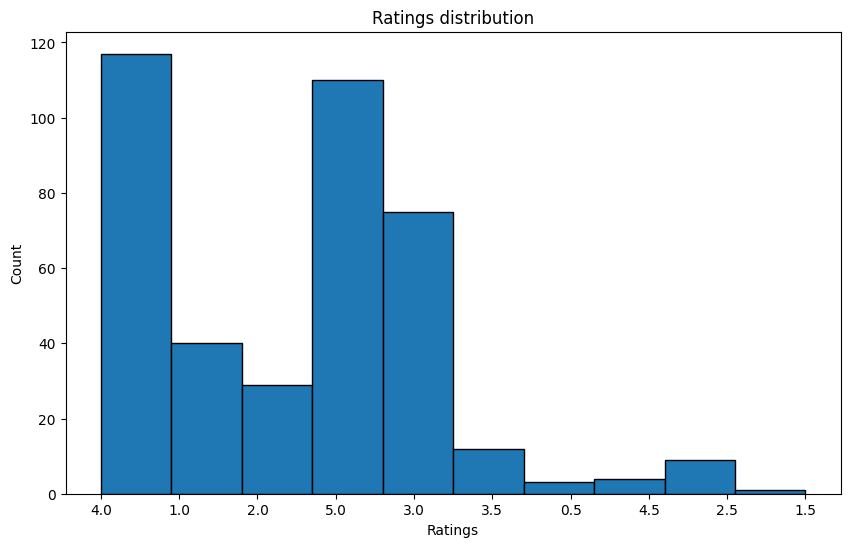

In [240]:
indexed_data.plot_data_item_distribution_as_hist(data_item="rating")

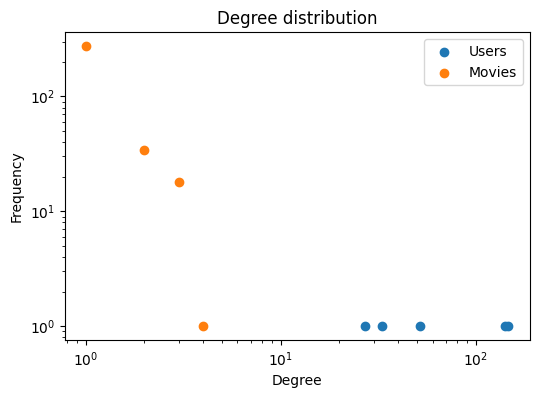

In [241]:
indexed_data.plot_power_low_distribution()

## Practical 2: biases only

In [242]:
(data_by_user_id__train, data_by_item_id__train), (
    data_by_user_id__test,
    data_by_item_id__test,
) = indexed_data.split_into_train_test(ratio=TRAIN_TEST_SPLIT_RATIO)

# Sanity checks to ensure that everything is fine, if any assertion fails then
# there is  a dev bug that should be fixed before proceeding  (kind of unit tests)

assert len(data_by_user_id__train) == len(
    data_by_user_id__test
), "The user based matrix should have the save dimension both for the training dataset and the test dataset. And that dimension should correspond to the visited users' count."

assert len(data_by_item_id__train) == len(
    data_by_item_id__test
), "The movie based matrix should have the save dimension both for the training dataset and the test dataset. And that dimension should correspond to the visited movies' count."

assert sum(len(data_by_user_id__test[i]) for i in data_by_user_id__test) == math.floor(
    TRAIN_TEST_SPLIT_RATIO * LINES_COUNT_TO_READ
)

assert sum(
    len(data_by_user_id__train[i]) for i in data_by_user_id__train
) == math.floor((1 - TRAIN_TEST_SPLIT_RATIO) * LINES_COUNT_TO_READ)

In [243]:
als_model = AlternatingLeastSquares(
    hyper_lambda=ALS_HYPER_LAMBDA,
    hyper_gamma=ALS_HYPER_GAMMA,
    hyper_tau=ALS_HYPER_TAU,
    hyper_n_epochs=ALS_HYPER_N_EPOCH,
    hyper_n_factors=ALS_HYPER_N_FACTOR,
    user_id_getter=lambda user: indexed_data.id_to_user_bmap.inverse[user],
    item_id_getter=lambda item: indexed_data.id_to_item_bmap.inverse[item],
    matrix_shape=(len(indexed_data.data_by_user_id), len(indexed_data.data_by_item_id)),
)

Successfully initialized the model state to: AlsState(user_factors=array([[-0.3512691 ,  0.61989033],
       [-1.08199703,  0.77652406],
       [ 1.62141887, -0.2634158 ],
       [ 0.1455379 , -0.40571715],
       [-0.38673311, -0.43919165]]), item_factors=array([[-9.66246085e-01, -8.03188770e-01],
       [-1.05828790e-01, -9.03362800e-01],
       [ 1.10544803e+00,  9.70253600e-01],
       [-2.97015896e-01,  6.76790486e-01],
       [-9.68549903e-01,  4.02306322e-01],
       [ 5.33028266e-03, -1.28689526e+00],
       [-1.91018154e-01,  2.29954472e-01],
       [ 3.32035871e-01, -3.54709261e-02],
       [ 8.28884832e-01, -1.09564686e-01],
       [-3.08088901e-01, -1.61341479e-01],
       [-5.99837114e-01, -2.16149124e-01],
       [ 8.54120699e-01,  7.86923197e-02],
       [ 3.28252634e-01,  1.26286484e+00],
       [-8.54180933e-01,  4.85091285e-01],
       [ 1.23544147e-02, -1.28887440e+00],
       [-7.42903310e-01,  1.11800527e-01],
       [-2.73942093e-01, -7.50860853e-02],
       [-2.9

In [244]:
als_model.fit(
    data_by_user_id__train,
    data_by_item_id__train,
    data_by_user_id__test,
    data_by_item_id__test,
)

Checkpoint successfully saved at 20241029-230837_lambda0.1_gamma0.01_tau1_epochs4_factors2_input400_lambda0.1


In [245]:
def plot_als_train_test_rmse_evolution(als_model):  # noqa
    """
    Plots the error evolution over iterations for a given set of error values.

    Parameters:
    error_values: List or array of error values (e.g., RMSE, loss) for each iteration.
    label: Label for the plot (default is "Test MSE").
    """
    iterations = range(1, len(als_model.epochs_rmse_train) + 1)

    # Plotting the error values
    plt.plot(iterations, als_model.epochs_rmse_train, label="Train RMSE", color="blue")
    plt.plot(iterations, als_model.epochs_rmse_test, label="Test RMSE", color="red")
    # Adding titles and labels
    plt.title("RMSE Evolution Over Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")

    # Show legend
    plt.legend()

    plt.savefig(get_plt_figure_path("rmse_test_train"))

    # Display the plot
    plt.show()


def plot_als_train_test_loss_evolution(als_model):  # noqa
    """
    Plots the loss evolution over iterations for the given ALS model.

    Parameters:
    als_model: Object containing 'epochs_loss_train' and 'epochs_loss_test'
               attributes that represent the loss values for each iteration.
    """
    iterations = range(1, len(als_model.epochs_loss_train) + 1)

    # Plotting the loss values
    plt.plot(iterations, als_model.epochs_loss_train, label="Train Loss", color="blue")
    plt.plot(iterations, als_model.epochs_loss_test, label="Test Loss", color="red")

    # Adding titles and labels
    plt.title("Loss Evolution Over Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    # Show legend
    plt.legend()
    plt.savefig(get_plt_figure_path("loss_test_train"), format=PLT_FIGURE_FORMAT)

    # Display the plot
    plt.show()


def plot_error_evolution(
    error_values,
    label="Error",
    title="Error Evolution Over Iterations",
    ylabel="Error",
    color="blue",
):
    """
    Plots the error evolution over iterations for a given set of error values.

    Parameters:
    error_values: List or array of error values (e.g., RMSE, loss) for each iteration.
    label: Label for the plot (default is "Error").
    title: Title for the plot (default is "Error Evolution Over Iterations").
    ylabel: Y-axis label (default is "Error").
    """
    iterations = range(1, len(error_values) + 1)

    # Plotting the error values
    plt.plot(iterations, error_values, label=label, color=color)

    # Adding titles and labels
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel(ylabel)

    # Show legend
    plt.legend()
    plt.savefig(
        get_plt_figure_path(title.lower().replace(" ", "_")), format=PLT_FIGURE_FORMAT
    )

    # Display the plot
    plt.show()

### Train and test RMSE

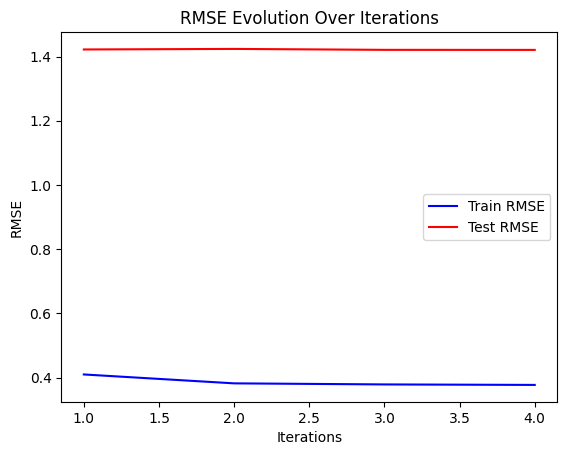

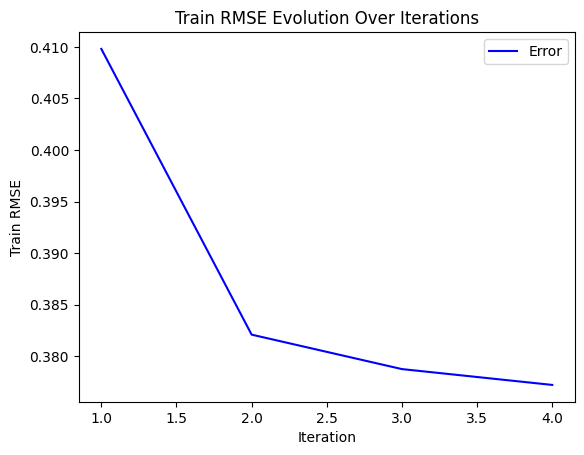

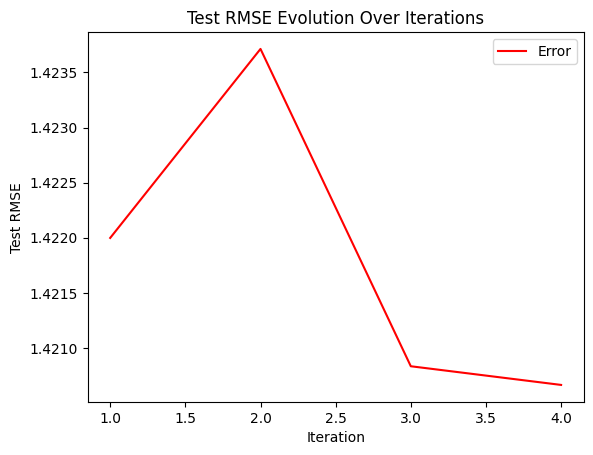

In [246]:
plot_als_train_test_rmse_evolution(als_model)
plot_error_evolution(
    als_model.epochs_rmse_train,
    ylabel="Train RMSE",
    title="Train RMSE Evolution Over Iterations",
)
plot_error_evolution(
    als_model.epochs_rmse_test,
    ylabel="Test RMSE",
    title="Test RMSE Evolution Over Iterations",
    color="red",
)

### Train and test loss

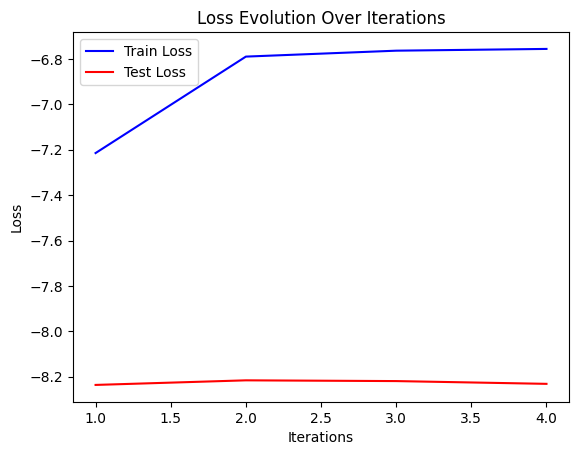

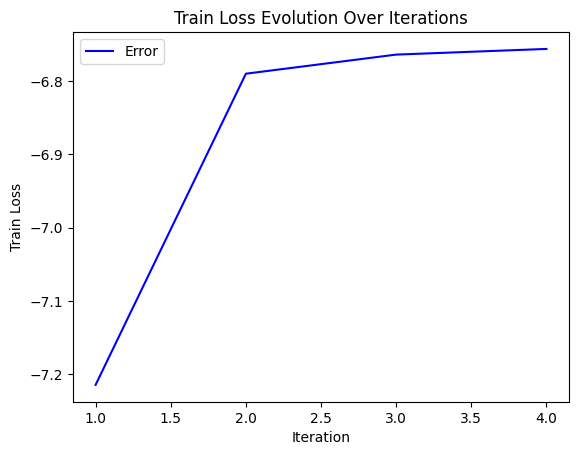

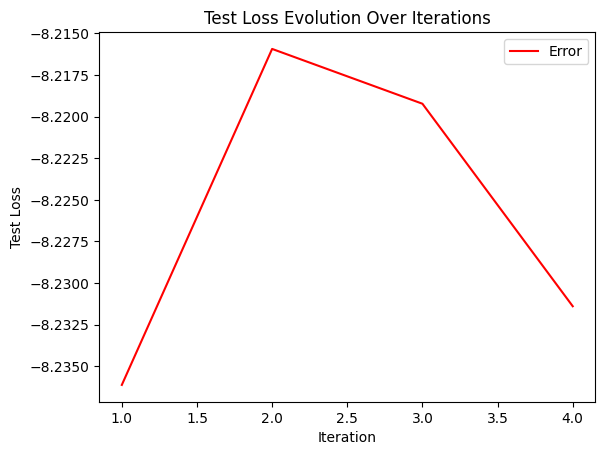

In [247]:
plot_als_train_test_loss_evolution(als_model)

plot_error_evolution(
    als_model.epochs_loss_train,
    ylabel="Train Loss",
    title="Train Loss Evolution Over Iterations",
)

plot_error_evolution(
    als_model.epochs_loss_test,
    ylabel="Test Loss",
    title="Test Loss Evolution Over Iterations",
    color="red",
)

In [248]:
import numpy as np
from matplotlib import pyplot as plt

u = np.arange(-5, 5, 0.25)

In [249]:
v = np.arange(-5, 5, 0.25)

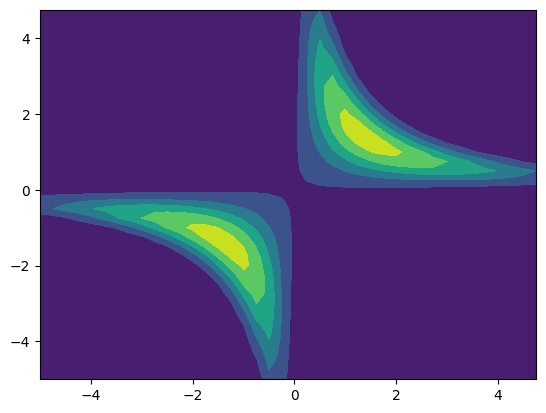

In [250]:
tau = 0.1
lambda_param = 1
r = 2
U, V = np.meshgrid(u, v)
P = (
    np.exp(-0.5 * lambda_param * ((r - (U * V)) ** 2))
    * np.exp(-0.5 * tau * (U**2))
    * np.exp(-0.5 * tau * (V**2))
)

surf = plt.contourf(U, V, P)

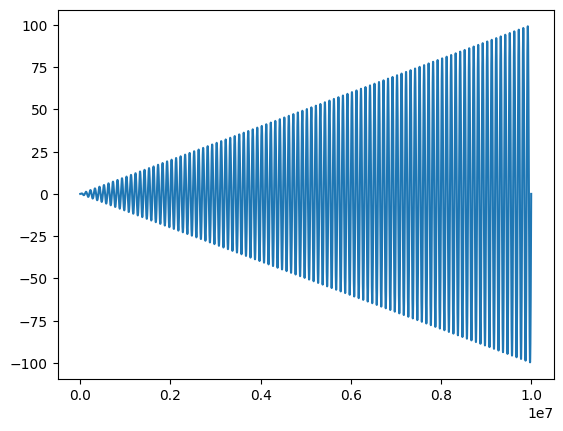

In [251]:
x = np.arange(0, 100, 0.00001)
y = x * np.sin(2 * np.pi * x)
plt.plot(y)
plt.savefig("test.svg", format="svg")